# Purposes of this document

set up tracking linear weights tools

the observation fit a

firing_rates = C x states +  Q

we need to track the weights change in C
as well as how the goodness of the fit using

# ideas

# Experimental setup related to the questions

this part should be configured to directly test the hypothesis put forward in the previous section


In [1]:
from features.simulation_features import get_enc_setup

#neuron set up : 'std (20 neurons)' or 'toy (4 neurons)' 
N_NEURONS, N_STATES, sim_C = get_enc_setup(sim_mode = 'std')

print('examine the encoder weights distribution')
print('We expect the only the first four neurons carry information:')
print(sim_C)

features.simulation_features: get_enc_setup has a tuning_level of 1 

examine the encoder weights distribution
We expect the only the first four neurons carry information:
[[ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/blackrock/cerelink.py:13: UserWarning: Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system
  warnings.warn("Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system")


In [2]:
import numpy as np

#encoder mean firing rate
neuron_firing_rates  = [100, 100]

#for comparision
exp_conds = [f'enc. mean FR:{b} Hz' for b in neuron_firing_rates]


#setting clda parameters 
##learner: collects paird data at batch_sizes
RHO = 0.5
batch_size = 50


#assistor set up assist level
assist_level = (0.05, 0.0)

#learner and updater: actualy set up rho
UPDATER_BATCH_TIME = 1
UPDATER_HALF_LIFE = np.log(RHO)  * UPDATER_BATCH_TIME / np.log(0.5)


In [3]:
# CHANGE: game mechanics: generate task params
N_TARGETS = 8
N_TRIALS = 80

NUM_EXP = len(exp_conds) # how many experiments we are running. 

# Config the experiments

this section largely copyied and pasted from   
bmi3d-sijia(branch)-bulti_in_experiemnts
https://github.com/sijia66/brain-python-interface/blob/master/built_in_tasks/sim_task_KF.py

## load dependant libraries

In [4]:
# import libraries
# make sure these directories are in the python path., 
from bmimultitasks import SimBMIControlMulti, SimBMICosEncKFDec, BMIControlMultiNoWindow
from features import SaveHDF
from features.simulation_features import get_enc_setup, SimKFDecoderRandom, SimCosineTunedEnc,SimIntentionLQRController, SimClockTick
from features.simulation_features import SimHDF, SimTime

from riglib import experiment

from riglib.stereo_opengl.window import FakeWindow
from riglib.bmi import train

from weights import calc_p_values_for_spike_batches_use_intended_kin
from weights import calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts
import weights

import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import itertools #for identical sequences

np.set_printoptions(precision=2, suppress=True)


##  behaviour and task setup

In [5]:
seq = SimBMIControlMulti.sim_target_seq_generator_multi(
N_TARGETS, N_TRIALS)

#create a second version of the tasks
seqs = itertools.tee(seq, NUM_EXP + 1)
target_seq = list(seqs[NUM_EXP])

seqs = seqs[:NUM_EXP]


SAVE_HDF = False
SAVE_SIM_HDF = True #this makes the task data available as exp.task_data_hist
DEBUG_FEATURE = False


#base_class = SimBMIControlMulti
base_class = BMIControlMultiNoWindow

#for adding experimental features such as encoder, decoder
feats = []

## encoder

the cosine tuned encoder uses a poisson process, right
https://en.wikipedia.org/wiki/Poisson_distribution
so if the lambda is 1, then it's very likely 

In [6]:
ENCODER_TYPE = 'cosine_tuned_encoder'



#actually multiply out the firing rates. 
sim_C_all = [sim_C * nfr for nfr in neuron_firing_rates]


#set up intention feedbackcontroller
#this ideally set before the encoder
feats.append(SimIntentionLQRController)

#set up the encoder
if ENCODER_TYPE == 'cosine_tuned_encoder' :
    feats.append(SimCosineTunedEnc)
    print(f'{__name__}: selected SimCosineTunedEnc\n')

__main__: selected SimCosineTunedEnc



## decoder setup

In [7]:
#clda on random 
DECODER_MODE = 'random' # random 

   #take care the decoder setup
if DECODER_MODE == 'random':
    feats.append(SimKFDecoderRandom)
    print(f'{__name__}: set base class ')
    print(f'{__name__}: selected SimKFDecoderRandom \n')
else: #defaul to a cosEnc and a pre-traind KF DEC
    from features.simulation_features import SimKFDecoderSup
    feats.append(SimKFDecoderSup)
    print(f'{__name__}: set decoder to SimKFDecoderSup\n')

__main__: set base class 
__main__: selected SimKFDecoderRandom 



##  clda: learner and updater

In [8]:


LEARNER_TYPE = 'feedback' # to dumb or not dumb it is a question 'feedback'
UPDATER_TYPE = 'smooth_batch' #none or "smooth_batch"


#you know what? 
#learner only collects firing rates labeled with estimated estimates
#we would also need to use the labeled data
#now, we can set up a dumb/or not-dumb learner
if LEARNER_TYPE == 'feedback':
    from features.simulation_features import SimFeedbackLearner
    feats.append(SimFeedbackLearner)
else:
    from features.simulation_features import SimDumbLearner
    feats.append(SimDumbLearner)

#to update the decoder.
if UPDATER_TYPE == 'smooth_batch':
    from features.simulation_features import SimSmoothBatch
    feats.append(SimSmoothBatch)
else: #defaut to none 
    print(f'{__name__}: need to specify an updater')
    



## assistor setup

## (Check) config the experiment

In [9]:
if DEBUG_FEATURE: 
    from features.simulation_features import DebugFeature
    feats.append(DebugFeature)
    
if SAVE_HDF: feats.append(SaveHDF)
if SAVE_SIM_HDF: feats.append(SimHDF)
    
    
#pass the real time limit on clock
feats.append(SimClockTick)
feats.append(SimTime)


kwargs_exps = list()

for i in range(NUM_EXP):
    d = dict()
    
    d['assist_level'] = assist_level
    d['sim_C'] = sim_C_all[i]
    d['batch_size'] = batch_size
    
    d['batch_time'] = UPDATER_BATCH_TIME
    d['half_life'] = UPDATER_HALF_LIFE
    
    kwargs_exps.append(d)


kwargs_exps

[{'assist_level': (0.05, 0.0),
  'sim_C': array([[   0.,    0.,    0.,  100.,    0.,    0.,    0.],
         [   0.,    0.,    0., -100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,  100.,    0.],
         [   0.,    0.,    0.,    0.,    0., -100.,    0.],
         [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,    0.,    0.],


## make and initalize experiment instances

In [10]:
#seed the experiment
np.random.seed(0)

#spawn the task
Exp = experiment.make(base_class, feats=feats)

exps = list()#create a list of experiment

for i,s in enumerate(seqs):
    e = Exp(s, **kwargs_exps[i])
    exps.append(e)

#run the ini
for e in exps: e.init()

metaclass constructor
(<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>, <class 'bmimultitasks.BMIControlMultiNoWindow'>)
[<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>]

features.simulation_features.SimInte

# Pre-experiment check: check the Kalman filter before training

we replace the encoder using the weights
assume, they are all randomly initialized get the first decoder
get a handle to the first decoder
we check the new decoder C matrix:


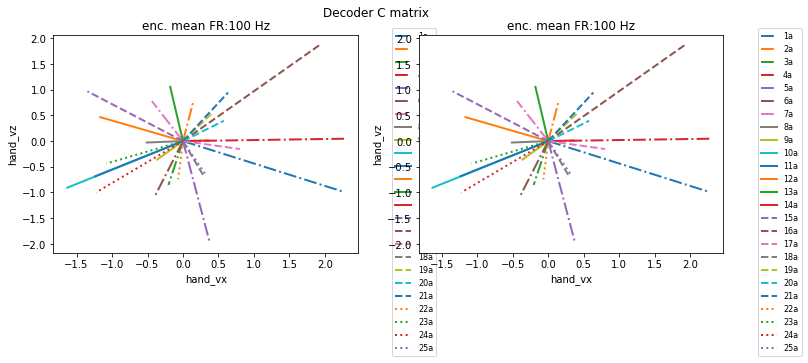

In [11]:
print('we replace the encoder using the weights')
print('assume, they are all randomly initialized get the first decoder')
print('get a handle to the first decoder')
first_decoder = exps[0].decoder
target_C = first_decoder.filt.C
    
#replace the decoder
for i,e in enumerate(exps):
    weights.change_target_kalman_filter_with_a_C_mat(e.decoder.filt, target_C, debug=False)
    
print('we check the new decoder C matrix:')

decoder_c_figure, axs = plt.subplots(nrows=1, 
                               ncols=NUM_EXP, figsize = [12,4])
decoder_c_figure.suptitle('Decoder C matrix ')

for i,e in enumerate(exps):
    e.decoder.plot_C(ax = axs[i])
    axs[i].set_title(exp_conds[i])

# Experiment run: assemble into a complete loop

##  define the function

In [12]:
#make this into a loop

def run_exp_loop(exp,  **kwargs):
        # riglib.experiment: line 597 - 601
    #exp.next_trial = next(exp.gen)
    # -+exp._parse_next_trial()np.arraynp.array


    # we need to set the initial state
    # per fsm.run:  line 138


    # Initialize the FSM before the loop
    exp.set_state(exp.state)
    
    finished_trials = exp.calc_state_occurrences('wait')
    print(f'finished: {finished_trials}')


    while exp.state is not None:

        # exp.fsm_tick()

        ### Execute commands#####
        exp.exec_state_specific_actions(exp.state)

        ###run the bmi loop #####
        # _cycle

        # bmi feature extraction, eh
        #riglib.bmi: 1202
        feature_data = exp.get_features()

        # Determine the target_state and save to file
        current_assist_level = exp.get_current_assist_level()
        target_state = exp.get_target_BMI_state(exp.decoder.states)

        # Determine the assistive control inputs to the Decoder
        #update assistive control level
        exp.update_level()
        if np.any(current_assist_level) > 0:
            current_state = exp.get_current_state()

            if target_state.shape[1] > 1:
                assist_kwargs = exp.assister(current_state, 
                                             target_state[:,0].reshape(-1,1), 
                                             current_assist_level, mode= exp.state)
            else:
                assist_kwargs = exp.assister(current_state, 
                                              target_state, 
                                              current_assist_level, 
                                              mode= exp.state)

            kwargs.update(assist_kwargs)
            
        

        # decode the new features
        # riglib.bmi.bmiloop: line 1245
        neural_features = feature_data[exp.extractor.feature_type]

        # call decoder.
        #tmp = exp.call_decoder(neural_features, target_state, **kwargs)
        neural_obs = neural_features
        learn_flag = exp.learn_flag
        task_state = exp.state

        n_units, n_obs = neural_obs.shape
        # If the target is specified as a 1D position, tile to match
        # the number of dimensions as the neural features
        if np.ndim(target_state) == 1 or (target_state.shape[1] == 1 and n_obs > 1):
            target_state = np.tile(target_state, [1, n_obs])

        decoded_states = np.zeros([exp.bmi_system.decoder.n_states, n_obs])
        update_flag = False

        for k in range(n_obs):
            neural_obs_k = neural_obs[:, k].reshape(-1, 1)
            target_state_k = target_state[:, k]

            # NOTE: the conditional below is *only* for compatibility with older Carmena
            # lab data collected using a different MATLAB-based system. In all python cases,
            # the task_state should never contain NaN values.
            if np.any(np.isnan(target_state_k)):
                task_state = 'no_target'

            #################################
            # Decode the current observation
            #################################
            decodable_obs, decode = exp.bmi_system.feature_accumulator(
                neural_obs_k)
            if decode:  # if a new decodable observation is available from the feature accumulator
                prev_state = exp.bmi_system.decoder.get_state()

                exp.bmi_system.decoder(decodable_obs, **kwargs)
                # Determine whether the current state or previous state should be given to the learner
                if exp.bmi_system.learner.input_state_index == 0:
                    learner_state = exp.bmi_system.decoder.get_state()
                elif exp.bmi_system.learner.input_state_index == -1:
                    learner_state = prev_state
                else:
                    print(("Not implemented yet: %d" %
                           exp.bmi_system.learner.input_state_index))
                    learner_state = prev_state

                if learn_flag:
                    exp.bmi_system.learner(decodable_obs.copy(), learner_state, target_state_k, exp.bmi_system.decoder.get_state(
                    ), task_state, state_order=exp.bmi_system.decoder.ssm.state_order)

            decoded_states[:, k] = exp.bmi_system.decoder.get_state()

            ############################
            # Update decoder parameters
            ############################
            if exp.bmi_system.learner.is_ready():
                batch_data = exp.bmi_system.learner.get_batch()
                batch_data['decoder'] = exp.bmi_system.decoder
                kwargs.update(batch_data)
                exp.bmi_system.updater(**kwargs)
                exp.bmi_system.learner.disable()

            new_params = None  # by default, no new parameters are available
            if exp.bmi_system.has_updater:
                new_params = copy.deepcopy(exp.bmi_system.updater.get_result())

            # Update the decoder if new parameters are available
            if not (new_params is None):
                exp.bmi_system.decoder.update_params(
                    new_params, **exp.bmi_system.updater.update_kwargs)
                new_params['intended_kin'] = batch_data['intended_kin']
                new_params['spike_counts_batch'] = batch_data['spike_counts']

                exp.bmi_system.learner.enable()
                update_flag = True

                # Save new parameters to parameter history
                exp.bmi_system.param_hist.append(new_params)



        # saved as task data
        # return decoded_states, update_flag
        tmp = decoded_states
        exp.task_data['internal_decoder_state'] = tmp

        # reset the plant position
        # @riglib.bmi.BMILoop.move_plant  line:1254
        exp.plant.drive(exp.decoder)

        # check state transitions and run the FSM.
        current_state = exp.state

        # iterate over the possible events which could move the task out of the current state
        for event in exp.status[current_state]:
            # if the event has occurred
            if exp.test_state_transition_event(event):
                # execute commands to end the current state
                exp.end_state(current_state)

                # trigger the transition for the event
                exp.trigger_event(event)

                # stop searching for transition events (transition events must be
                # mutually exclusive for this FSM to function properly)
                break

        # sort out the loop params.
        # inc cycle count
        exp.cycle_count += 1

        # save target data as was done in manualControlTasks._cycle
        exp.task_data['target'] = exp.target_location.copy()
        exp.task_data['target_index'] = exp.target_index

        #done in bmi:_cycle after move_plant
        exp.task_data['loop_time'] = exp.iter_time()


        #fb_controller data
        exp.task_data['target_state'] = target_state

        #encoder data
        #input to this is actually extractor
        exp.task_data['ctrl_input'] = np.reshape(exp.extractor.sim_ctrl, (1,-1))

        #actually output
        exp.task_data['spike_counts'] = feature_data['spike_counts']


        #save the decoder_state
        #from BMILoop.move_plant
        exp.task_data['decoder_state'] = exp.decoder.get_state(shape=(-1,1))
        
        #save bmi_data
        exp.task_data['update_bmi'] = update_flag


        # as well as plant data.
        plant_data = exp.plant.get_data_to_save()
        for key in plant_data:
            exp.task_data[key] = plant_data[key]

        # clda data handled in the above call.

        # save to the list hisory of data.
        exp.task_data_hist.append(exp.task_data.copy())
        
        #print out the trial update whenever wait count changes, alright. 
        if finished_trials != exp.calc_state_occurrences('wait'):
            finished_trials = exp.calc_state_occurrences('wait')
            print(f'finished trials :{finished_trials} with a current assist level of {exp.get_current_assist_level()}')


    if exp.verbose:
        print("end of FSM.run, task state is", exp.state)
    
    


## actually running the experiments

In [13]:
for i,e in enumerate(exps):
    run_exp_loop(e, **kwargs_exps[i])
    print(f'Finished running  {exp_conds[i]}')

runseq
finished: 1
assist_level:  0.05
finished trials :2 with a current assist level of 0.049375


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/bmi/kfdecoder.py:372: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C = np.mat(np.linalg.lstsq(X.T, Y.T)[0].T)


finished trials :3 with a current assist level of 0.048823611111111116
finished trials :4 with a current assist level of 0.04855555555555556
finished trials :5 with a current assist level of 0.048322222222222225
finished trials :6 with a current assist level of 0.048106944444444445
finished trials :7 with a current assist level of 0.047822222222222224
finished trials :8 with a current assist level of 0.04761388888888889
finished trials :9 with a current assist level of 0.04738194444444445
finished trials :10 with a current assist level of 0.04715833333333334
finished trials :11 with a current assist level of 0.046950000000000006
finished trials :12 with a current assist level of 0.04672361111111111
finished trials :13 with a current assist level of 0.046498611111111116
finished trials :14 with a current assist level of 0.046283333333333336
finished trials :15 with a current assist level of 0.046047222222222225
finished trials :16 with a current assist level of 0.04581666666666667
finis

finished trials :37 with a current assist level of 0.041183333333333336
finished trials :38 with a current assist level of 0.040975000000000004
finished trials :39 with a current assist level of 0.040775000000000006
finished trials :40 with a current assist level of 0.04054861111111111
finished trials :41 with a current assist level of 0.04034027777777778
finished trials :42 with a current assist level of 0.040100000000000004
assist_level:  0.04
finished trials :43 with a current assist level of 0.039875
finished trials :44 with a current assist level of 0.039655555555555555
finished trials :45 with a current assist level of 0.03944166666666667
finished trials :46 with a current assist level of 0.039231944444444444
finished trials :47 with a current assist level of 0.03900833333333333
finished trials :48 with a current assist level of 0.038788888888888894
finished trials :49 with a current assist level of 0.038580555555555555
finished trials :50 with a current assist level of 0.0383722

# Postprocessing the data for loading

In [14]:
for e in  exps: print(e.calc_state_occurrences('reward'))

80
80


## declare defs and conventions

In [15]:
FRAME_RATE = 60
INT_WINDOW_TIME = 10 # s for looking at sample raw data

# some conventions as we go down the loop
X_VEL_STATE_IND = 3
Y_VEL_STATE_IND = 5
X_POS_STATE_IND = 0
Y_POS_STATE_IND = 2

state_indices = [X_POS_STATE_IND,
                 Y_POS_STATE_IND,
                 X_VEL_STATE_IND,
                 Y_VEL_STATE_IND]
state_names = ['x pos ', 'y pos', 'x vel', 'y vel']


INT_WIN_SAMPLES = INT_WINDOW_TIME * FRAME_RATE



## Refactor out the data

In [16]:
task_data_hist_np_all = [np.array(e.task_data_hist) for e in exps]
len(task_data_hist_np_all)
task_data_hist_np_all[0].dtype

dtype([('cursor', '<f8', (3,)), ('obs_t', '<f8', (25, 1)), ('K', '<f8', (7, 25)), ('KC', '<f8', (7, 7)), ('pred_state_mean', '<f8', (7, 1)), ('post_state_mean', '<f8', (7, 1)), ('pred_state_P', '<f8', (7, 7)), ('post_state_P', '<f8', (7, 7)), ('loop_time', '<f8', (1,)), ('decoder_state', '<f8', (7, 1)), ('internal_decoder_state', '<f8', (7, 1)), ('target_state', '<f8', (7, 1)), ('update_bmi', '<f8', (1,)), ('spike_counts', '<f8', (25, 1)), ('bin_edges', '<f8', (2,)), ('ctrl_input', '<f8', (7,)), ('assist_level', '<f8', (1,)), ('target', '<f8', (3,)), ('target_index', '<i4', (1,))])

## Finished time in seconds

In [17]:
finished_times_in_seconds = [int(len(s)/FRAME_RATE) for s in task_data_hist_np_all]
finished_times_in_seconds

[226, 230]

# Post data analysis

## Overall  trial statistics succuss rate)

In [18]:
def filter_state(state_log:list, state_to_match:str)->list:
    '''#set axis limits of plot (x=0 to 20, y=0 to 20)
plt.axis([0, 20, 0, 20])
plt.axis("equal")

    state_log: a list of tuples (state:string, start_time: float)
    state_to_watch
    
    returns a list of element type
    '''
    
    return list(filter(lambda k: k[0] == state_to_match, state_log) )

def calc_inter_wait_times(wait_log: list)-> list:
    """
    state_log: a list of tuples ("wait", start_time: float)
    return a list of tuples: ("wait", start_time: float, diff_time)
    """
    wait_log_with_diff = list()
    for i, wait_state in enumerate(wait_log):
        if i == len(wait_log)-1: #there is nothing to subtract, just put zero.
            wait_log_with_diff.append((wait_state[1],  0))
            
        else:
            finish_time = wait_log[i+1][1]
            wait_log_with_diff.append((wait_state[1],  finish_time - wait_state[1]))
    
    return np.array(wait_log_with_diff[:-1])

In [19]:
state_logs = [e.state_log for e in exps]


In [20]:
STATE_CUT_NAME =  'wait'
#get the state logs
wait_logs = [filter_state(s, STATE_CUT_NAME) for s in state_logs]

inter_wait_times = [calc_inter_wait_times(w) for w in wait_logs]
#this has both start times 

Text(0, 0.5, 'Trial time (s)')

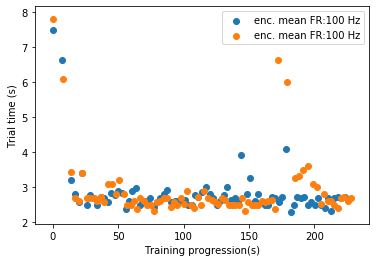

In [21]:


for i in inter_wait_times:
    plt.scatter(i[:,0], i[:,1])

plt.legend(exp_conds)
plt.xlabel('Training progression(s)')
plt.ylabel('Trial time (s)')

In [22]:
wait_time = inter_wait_times[0]
task_data_hist_np = task_data_hist_np_all[0]



In [23]:
def sort_trials(wait_time:list, 
                target_seq:list,
                task_data_hist_np:dict, 
                dict_keys, FRAME_RATE = 60):
    trial_dict = list()
    
    for i,row in enumerate(wait_time):
        start_time = row[0]
        inter_wait_time = row[1]

        start_sample = int(start_time * FRAME_RATE)
        inter_wait_sample = int(inter_wait_time * FRAME_RATE)
        stop_sample = start_sample + inter_wait_sample

        single_trial_dict = dict()

        for k in dict_keys:
            
            requested_type_data = np.squeeze(task_data_hist_np[k])
            single_trial_dict[k] =  requested_type_data[start_sample:stop_sample,
                                                       :]
        #add more info
        single_trial_dict['start_time'] = row[0]
        single_trial_dict['inter_wait_time'] = row[1]
        
        #add target info
        single_trial_dict['targets'] = target_seq[i]

        #add the dictionary to the list
        trial_dict.append(single_trial_dict)
        
    return trial_dict



In [24]:


trial_dicts_all = []
dict_keys = ['cursor', #behaviour
             'ctrl_input', 'spike_counts', #encoder translates intended ctrl into spike counts
             'decoder_state']

for i in range(NUM_EXP):
    wait_time = inter_wait_times[i]
    task_data_hist_np = task_data_hist_np_all[i]
    
    trial_dict_0 = sort_trials(wait_time, 
                               target_seq,
                               task_data_hist_np, dict_keys)
    
    trial_dicts_all.append(trial_dict_0)

len(trial_dicts_all)

2

## Trajectory analysis

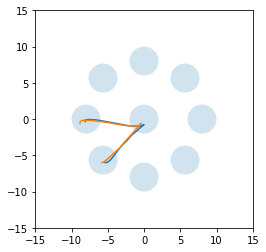

In [25]:
n_roi_trials = N_TRIALS - 1
unique_targets =  np.unique(target_seq, axis = 0)


X_CURSOR = 0
Z_CURSOR = 2
CIRCL_ALPHA = 0.2



RANGE_LIM =  15
figure, axes = plt.subplots() 

axes.set_xlim(-RANGE_LIM, RANGE_LIM)
axes.set_ylim(-RANGE_LIM, RANGE_LIM)

CIRCLE_RADIUS = exps[0].target_radius

#plot the targets

#plot the origin

cc = plt.Circle((0,0 ), 
            radius = CIRCLE_RADIUS,
            alpha = CIRCL_ALPHA)

axes.add_artist( cc ) 

for origin_t in unique_targets:
    origin = origin_t[0]
    t = origin_t[1]

    cc = plt.Circle((t[X_CURSOR],t[Z_CURSOR] ), 
                    radius = CIRCLE_RADIUS,
                    alpha = CIRCL_ALPHA)
                     
    axes.set_aspect( 1 ) 
    axes.add_artist( cc ) 
    
    
for trial_dict in trial_dicts_all:
    
    sample_trial = trial_dict[n_roi_trials]
    trial_cursor_trajectory = sample_trial['cursor']
    
    
    axes.plot(trial_cursor_trajectory[:, X_CURSOR], 
             trial_cursor_trajectory[:, Z_CURSOR])



In [26]:
print('finished trials:')

for i,e in  enumerate(exps): 
    reward_num = e.calc_state_occurrences('reward')
    print(f'{exp_conds[i]}: {reward_num} out of {N_TRIALS}')

finished trials:
enc. mean FR:100 Hz: 80 out of 80
enc. mean FR:100 Hz: 80 out of 80


## encoder

the job of the encoder is to directly encode intention into firing rates
the direct measure is just pearson correlation coefficients between 
the intentions and the firing rates

In [27]:
print('the encoder observation Q matrix')
for i,e in enumerate(exps):
    print(exp_conds[i])
    print(e.encoder.ssm.w)

the encoder observation Q matrix
enc. mean FR:100 Hz
7
enc. mean FR:100 Hz
7


In [28]:
n_exp = 0


spike_count_sample = trial_dicts_all[n_exp][n_roi_trials]['spike_counts']

## decoder

steady state tuning curves:


Text(0, -0.27999999999999997, 'CLDA rho 0.5')

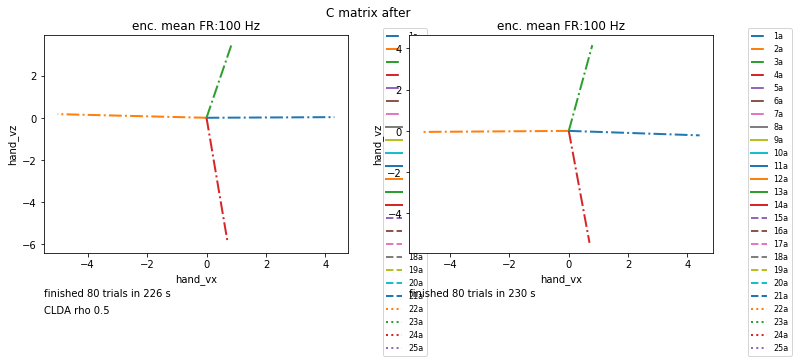

In [29]:
TEXT_OFFSET_VERTICAL = -0.2

decoder_c_after,axs = plt.subplots(1, NUM_EXP,
                                  figsize = (12,4))

decoder_c_after.suptitle('C matrix after')

print('steady state tuning curves:')
for i,e in enumerate(exps):
    e.decoder.plot_C(ax = axs[i])
    axs[i].set_title(exp_conds[i])
    
    #get the lower left coordinate
    y_lim_range  = axs[i].get_ylim()[1] - axs[i].get_ylim()[0]
    
    axs[i].text(0, TEXT_OFFSET_VERTICAL,
                f'finished {N_TRIALS} trials in {finished_times_in_seconds[i]} s', 
               transform = axs[i].transAxes)

decoder_c_after.text(0, 1.4 * TEXT_OFFSET_VERTICAL, 
                     f'CLDA rho {RHO}',
                    transform = axs[0].transAxes)


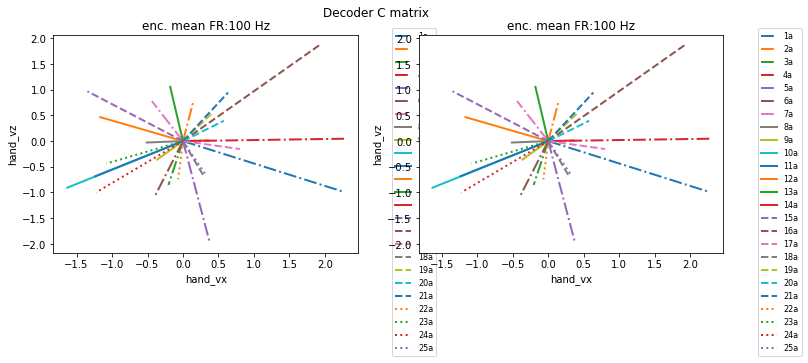

In [30]:
decoder_c_figure

## compare before and after the training

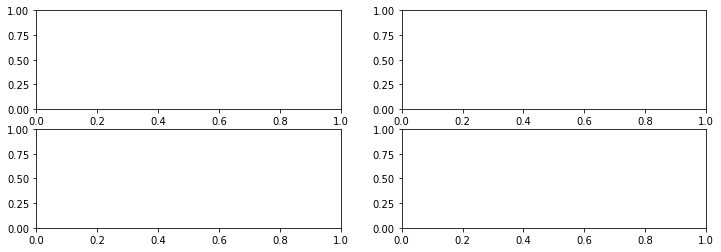

In [31]:


N_ROWS = 2 #before and after 
FIGURE_SIZE_2_by_4 = (12,4)
figure_compare_decoder_C_matrix,axs = plt.subplots(2,NUM_EXP, 
                                                   figsize = (12,4))

for i in range(NUM_EXP):
    axs[0, i] = decoder_c_figure.get_axes()[i]
    axs[1, i] = decoder_c_after.get_axes()[i]
    

# CLDA updates

## clda update frequencies

In [32]:

clda_params_all = [np.array(e.bmi_system.param_hist) for e in exps]

for c in clda_params_all:
    print(f'did clda for {len(c)} times')

did clda for 45 times
did clda for 46 times


In [33]:
update_bmi_all = np.squeeze(task_data_hist_np_all[0]['update_bmi'])

Text(0.5, 0, 'frame count')

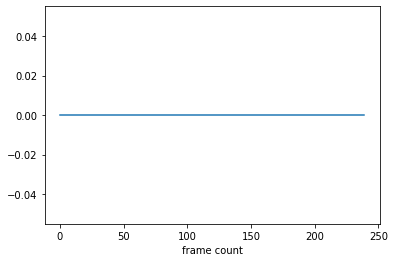

In [34]:
plt.plot(update_bmi_all[:240])
plt.xlabel('frame count')

## reformat the matrix

In [35]:
clda_params = clda_params_all[1]

clda_params_dict_all = list()

for p in clda_params_all:
    clda_params_dict = dict()
    for param_key in p[0].keys():
        clda_params_dict[param_key] = np.array([ record_i[param_key] for record_i in p])
    
    clda_params_dict_all.append(clda_params_dict)


len(clda_params_dict_all)

2

## observation covariance matrix

In [36]:
n_sample = 1

for i,c in enumerate(clda_params_dict_all):
    print(exp_conds[i])
    print(c['kf.Q'][n_sample,:,:])
    print()

enc. mean FR:100 Hz
[[31.19 -3.63 -2.75 -2.54  0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.  ]
 [-3.63 50.78  1.26  0.02  0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.  ]
 [-2.75  1.26 58.6  35.18  0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.  ]
 [-2.54  0.02 35.18 40.43  0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.  ]
 [ 0.    0.    0.    0.    2.5   0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.  ]
 [ 0.    0.    0.    0.    0.    2.5   0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.  ]
 [ 0.    0.    0.    0.    0.    0.    2.5   0.    0.    0.   

## clda K matrix

In [37]:
kf_C = clda_params_dict['kf.C']

In [38]:
print('K matrix before:')
print(kf_C[0,:,:])
print('K matrix after:')
print(kf_C[-1,:,:])

K matrix before:
[[ 0.    0.    0.    5.96  0.   -0.27 -1.06]
 [ 0.    0.    0.    0.04  0.    0.35  0.28]
 [ 0.    0.    0.    0.45  0.    3.96  0.73]
 [ 0.    0.    0.    2.15  0.    0.09 -1.32]
 [ 0.    0.    0.    0.19  0.   -0.99 -0.17]
 [ 0.    0.    0.   -0.19  0.   -0.52 -0.71]
 [ 0.    0.    0.   -0.22  0.    0.39 -0.81]
 [ 0.    0.    0.   -0.26  0.   -0.01  0.21]
 [ 0.    0.    0.   -0.18  0.   -0.18 -0.41]
 [ 0.    0.    0.   -0.82  0.   -0.45  0.03]
 [ 0.    0.    0.   -0.62  0.   -0.34 -0.44]
 [ 0.    0.    0.   -0.58  0.    0.23 -0.77]
 [ 0.    0.    0.   -0.09  0.    0.53 -0.2 ]
 [ 0.    0.    0.    0.18  0.    0.01  0.89]
 [ 0.    0.    0.   -0.67  0.    0.48 -0.59]
 [ 0.    0.    0.    0.96  0.    0.93  0.45]
 [ 0.    0.    0.    0.4   0.   -0.08  0.31]
 [ 0.    0.    0.    0.15  0.   -0.35 -0.07]
 [ 0.    0.    0.    0.2   0.    0.27 -0.34]
 [ 0.    0.    0.    0.29  0.    0.2  -0.55]
 [ 0.    0.    0.    0.32  0.    0.47 -0.46]
 [ 0.    0.    0.   -0.03  0.   -0.37 

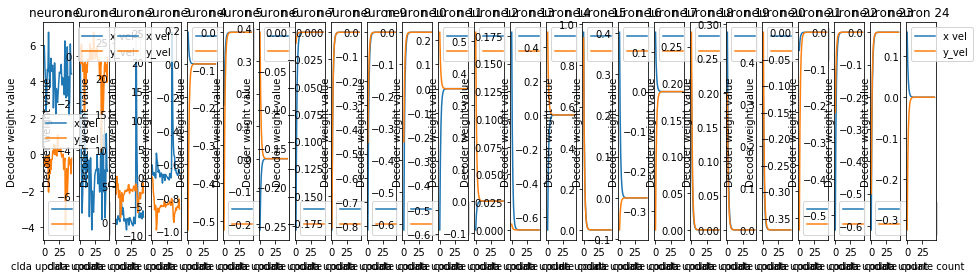

In [39]:
N_CLDA_ROI_TIME = 800

FIGURE_SIZE = (2,10)

N_NEURONS

f, axs = plt.subplots(1,N_NEURONS,figsize=(16,4))

for i in range(N_NEURONS):
    axs[i].plot(np.squeeze(kf_C[:N_CLDA_ROI_TIME,i, X_VEL_STATE_IND]))
    axs[i].plot(np.squeeze(kf_C[:N_CLDA_ROI_TIME,i, Y_VEL_STATE_IND]))
    axs[i].legend(['x vel', 'y_vel'])
    axs[i].set_title(f'neuron {i} ')
    axs[i].set_xlabel('clda update count ')
    axs[i].set_ylabel('Decoder weight value')



In [40]:
exps[0].encoder.C

array([[   0.,    0.,    0.,  100.,    0.,    0.,    0.],
       [   0.,    0.,    0., -100.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,  100.,    0.],
       [   0.,    0.,    0.,    0.,    0., -100.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,

## examine training batches

In [41]:
spike_counts_batch = clda_params_dict['spike_counts_batch'] 
intended_kin = clda_params_dict['intended_kin']

In [42]:
training_sample_point = 2

print('intended kinematics:')
print(intended_kin[training_sample_point])

print('spike counts:')
print(spike_counts_batch[training_sample_point])

print('trained KF C matrix:')
print(kf_C[training_sample_point])

intended kinematics:
[[ 7.46  7.14  6.73  6.35  5.94  5.6   5.24  4.94  4.56  4.24  3.93  3.55
   3.19  2.86  2.48  2.16  1.89  1.64  1.36  1.11  0.92  0.75  0.63  0.8
   1.07  1.43  1.72  1.96  2.31  2.65  2.98  3.29  3.61  3.89  4.22  4.48
   4.63  4.72  4.8   4.89  4.92  4.77  4.73  4.7   4.59  4.49  4.31  4.09
   3.84  3.63]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.  ]
 [ 3.45  3.1   2.58  1.93  1.45  0.88  0.44  0.02 -0.22 -0.35 -0.42 -0.46
  -0.48 -0.49 -0.51 -0.47 -0.46 -0.41 -0.42 -0.44 -0.43 -0.39 -0.31  0.37
   1.46  2.6   3.7   4.58  5.24  5.61  5.91  6.1   6.12  6.11  6.01  5.93
   5.87  5.8   5.77  5.75  5.67  5.08  4.21  3.43  2.68  2.    1.46  0.99
   0.59  0.22]
 [-5.76 -7.72 -8.06 -7.66 -7.46 -6.8  -6.56 -6.   -6.06

# Measure weights change

In [43]:
from weights_linear_regression import *
from afs_plotting import plot_prefered_directions

In [44]:
kf_C = clda_params_dict['kf.C']
kf_C.shape

(46, 25, 7)

In [45]:
history_of_L2_norms = calc_a_history_of_matrix_L2norms_along_first_axis(kf_C,
                                                                       (X_VEL_STATE_IND, Y_VEL_STATE_IND))

history_of_L2_norms.shape

(46, 25)

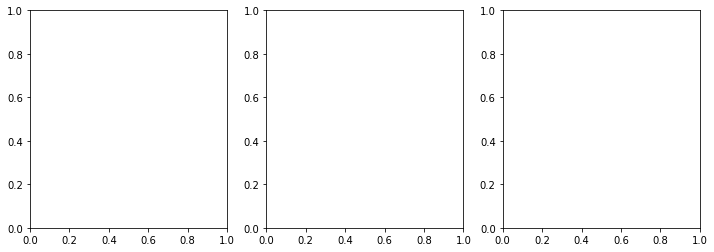

In [46]:
figure_compare_kf, axes_compare_kf = plt.subplots(1,3, figsize = (12, 4))

kf_slice has kf_slice has shape (25, 7)


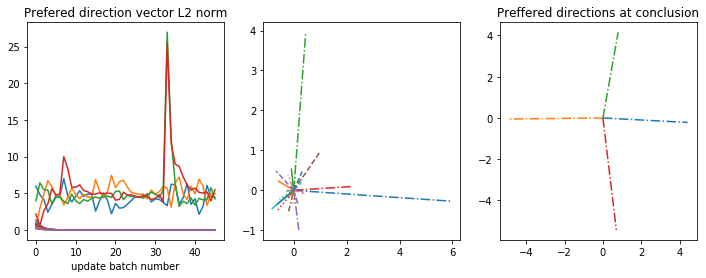

In [47]:
time_of_interest = 0
kf_slice_start = np.squeeze(kf_C[time_of_interest, :,:])
print(f'kf_slice has kf_slice has shape {kf_slice_start.shape}')

kf_slice_end = np.squeeze(kf_C[-1, :,:])


#plot the trajectjory
axes_compare_kf[0].plot(history_of_L2_norms)

#plot the begining 
plot_prefered_directions(kf_slice_start, 
                         ax = axes_compare_kf[1])
axes_compare_kf[0].set_title('Prefered direction vector L2 norm')
axes_compare_kf[0].set_xlabel('update batch number')



#plot the end
plot_prefered_directions(kf_slice_end, 
                         ax = axes_compare_kf[2])
axes_compare_kf[2].set_title('Preffered directions at conclusion')


figure_compare_kf

# Measure ssms

In [48]:
spike_counts_batch = clda_params_dict['spike_counts_batch'] 
intended_kin = clda_params_dict['intended_kin']

print(f'spike_counts_batch has the shape of {spike_counts_batch.shape}')
print(f'intended_kin has the shape of {intended_kin.shape}')

print(f'kf_C has the shape of {kf_C.shape}')


spike_counts_batch has the shape of (46, 25, 50)
intended_kin has the shape of (46, 7, 50)
kf_C has the shape of (46, 25, 7)


In [49]:
VEL_DECODING_STATES = (X_VEL_STATE_IND, Y_VEL_STATE_IND,)
print(f'we will only be looking the indices of the x vel and y vel {VEL_DECODING_STATES}')

time_slice_of_interest = 0
print(f'time slice of interest {time_slice_of_interest}')

spike_count_slice = np.squeeze(spike_counts_batch[time_slice_of_interest, :, :])
intended_kin_slice = np.squeeze(intended_kin[time_slice_of_interest, VEL_DECODING_STATES, :])
kf_C_slice = np.squeeze(kf_C[time_slice_of_interest, :,VEL_DECODING_STATES])

#rotate the dimensions=
spike_count_slice = spike_count_slice.T
intended_kin_slice = intended_kin_slice.T
kf_C_slice = kf_C_slice.T


print(f'spike_count_slice has the shape of {spike_count_slice.shape}')
print(f'intended_kin_slice has the shape of {intended_kin_slice.shape}')

print(f'kf_C_slice has the shape of {kf_C_slice.shape}')

we will only be looking the indices of the x vel and y vel (3, 5)
time slice of interest 0
spike_count_slice has the shape of (50, 25)
intended_kin_slice has the shape of (50, 2)
kf_C_slice has the shape of (25, 2)


In [50]:
from weights_linear_regression import calc_average_ssm_for_each_X_column

ssm_slice = calc_average_ssm_for_each_X_column(intended_kin_slice, spike_count_slice, kf_C_slice)

ssm_slice.shape

(25,)

## encapsulate into the batch

In [51]:
(N_BATCHES, N_NEURONS, N_POINTS_IN_A_BATCH)  =  spike_counts_batch.shape

#initialize an nan array
ssm_all_batches = np.empty((N_BATCHES, N_NEURONS))
ssm_all_batches[:] = np.nan

for n_batch in range(N_BATCHES):
    spike_count_slice = np.squeeze(spike_counts_batch[n_batch, :, :])
    intended_kin_slice = np.squeeze(intended_kin[n_batch, VEL_DECODING_STATES, :])
    kf_C_slice = np.squeeze(kf_C[n_batch,:,VEL_DECODING_STATES])
    
    #rotate the dimensions=
    spike_count_slice = spike_count_slice.T
    intended_kin_slice = intended_kin_slice.T
    kf_C_slice = kf_C_slice.T

    
    ssm_slice = calc_average_ssm_for_each_X_column(intended_kin_slice, 
                                                   spike_count_slice, 
                                                   kf_C_slice)
    ssm_all_batches[n_batch, :] = ssm_slice
    
    


look at these two neurons range(0, 8)


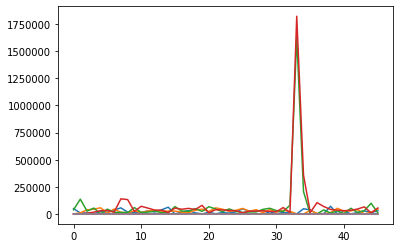

In [52]:
neurons_of_interest = range(8)

print(f'look at these two neurons {neurons_of_interest}')

plt.plot(ssm_all_batches[:, neurons_of_interest])

## over all ssm

In [53]:
(N_BATCHES, N_NEURONS, N_POINTS_IN_A_BATCH)  =  spike_counts_batch.shape

#initialize an nan array
ssm_all_batches = np.empty((N_BATCHES,))


for n_batch in range(N_BATCHES):
    spike_count_slice = np.squeeze(spike_counts_batch[n_batch, :, :])
    intended_kin_slice = np.squeeze(intended_kin[n_batch, VEL_DECODING_STATES, :])
    kf_C_slice = np.squeeze(kf_C[n_batch, :,VEL_DECODING_STATES])
    
    #rotate the dimensions=
    spike_count_slice = spike_count_slice.T
    intended_kin_slice = intended_kin_slice.T
    kf_C_slice = kf_C_slice.T
    
    ssm_slice = calc_ssm_y_minus_x_beta(intended_kin_slice, 
                                                   spike_count_slice, 
                                                   kf_C_slice)
    ssm_all_batches[n_batch] = ssm_slice
    
ssm_all_batches = ssm_all_batches / N_POINTS_IN_A_BATCH
    

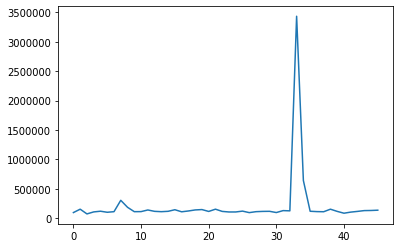

In [54]:
plt.plot(ssm_all_batches)


# feature analyses hypothesis testing

In [55]:
import statsmodels.api as sm


## Examine relevance of one neuron from one batch 

### Select data

In [56]:
clda_params_dict.keys() # this is from one experiment

dict_keys(['kf.C', 'kf.Q', 'kf.C_xpose_Q_inv_C', 'kf.C_xpose_Q_inv', 'mFR', 'sdFR', 'rho', 'intended_kin', 'spike_counts_batch'])

In [57]:
spike_counts_batch = clda_params_dict['spike_counts_batch']
intended_kin = clda_params_dict['intended_kin']
print(f'{len(spike_counts_batch)}')
print(f'{len(intended_kin)}')

46
46


In [58]:
# we just take one batch
batch_of_interest = 0
spike_count_one_batch = spike_counts_batch[batch_of_interest]
intended_kin_one_batch = intended_kin[batch_of_interest]

print(f'look at one batch: batch number {batch_of_interest}')
print(f'spike count')
print(spike_count_one_batch)

print(f'intended kin')
print(intended_kin_one_batch)

look at one batch: batch number 0
spike count
[[ 0.  0.  0. ...  5.  4.  7.]
 [ 0.  2.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ... 66. 83. 76.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
intended kin
[[  0.    -0.04  -0.07  -0.05   0.44   1.3    2.51   3.82   5.01   5.87
    6.46   6.94   7.2    7.35   7.41   7.5    7.51   7.5    7.5    7.48
    7.45   7.42   7.4    7.36   7.33   7.31   7.28   7.27   7.29   7.29
    7.29   7.3    7.33   7.3    7.28   7.31   7.32   7.32   7.32   7.36
    7.39   7.39   7.43   7.44   7.46   7.45   7.45   7.49   7.49   7.48]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  0.    -0.01  -0.02  -0.03  -0.4

In [59]:
print('we are dealing with a velocity decoder')
print('we only look at  x vel and y vel:')
print('We assume we are only interested how firing rates encode x, y vel')

intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:]
print('after selecting the vels:')
print(intended_kin_one_batch_2D)

we are dealing with a velocity decoder
we only look at  x vel and y vel:
We assume we are only interested how firing rates encode x, y vel
after selecting the vels:
[[ 0.   -0.19  6.76  6.85  9.16 10.69 11.83 11.47  9.79  7.16  5.01  3.85
   2.37  1.47  0.92  0.97  0.47  0.39  0.4   0.31  0.27  0.3   0.37  0.34
   0.34  0.45  0.43  0.57  0.66  0.62  0.57  0.65  0.74  0.41  0.51  0.73
   0.64  0.58  0.58  0.73  0.72  0.52  0.72  0.53  0.56  0.41  0.49  0.66
   0.44  0.37]
 [ 0.   -0.06 -0.02 -0.04 -1.71 -2.58 -3.11 -2.8  -1.8  -0.17  0.94  1.66
   2.39  2.99  3.27  3.46  3.92  3.84  4.14  4.17  4.14  4.23  4.39  4.33
   4.95  4.92  5.13  4.95  5.    5.43  5.6   5.43  5.79  5.9   6.02  6.07
   6.36  6.42  6.75  6.49  7.02  7.36  7.34  7.82  8.05  8.29  8.33  8.32
   9.12  9.07]]


In [60]:
print('we will do  one neuron at a time')
n_roi_neuron = 0
print(f'the neuron that we are interested is neuron {n_roi_neuron}')
print('and selected firing rates:')

spike_count_one_batch_one_neuron = spike_count_one_batch[n_roi_neuron,:]

print(spike_count_one_batch_one_neuron)

we will do  one neuron at a time
the neuron that we are interested is neuron 0
and selected firing rates:
[  0.   0.   0.  55.  87. 115. 123. 114.  85.  71.  59.  35.  21.  12.
  15.   5.   4.   4.   2.   1.   1.   2.   1.   0.   2.   1.   4.   6.
   5.   4.   6.   8.   1.   3.   8.   6.   5.   5.   9.   9.   5.  10.
   6.   7.   4.   6.  10.   5.   4.   7.]


### OLS model fitting

In [61]:
print('we transpose the vector for fitting')
X = intended_kin_one_batch_2D.T
y = np.reshape(spike_count_one_batch_one_neuron, (-1,1))


print('the independent variables are  the intended kin hence, X')
print(X)


print('the dependent variable is the neuron spike connt, hence y')
print(y)


we transpose the vector for fitting
the independent variables are  the intended kin hence, X
[[ 0.    0.  ]
 [-0.19 -0.06]
 [ 6.76 -0.02]
 [ 6.85 -0.04]
 [ 9.16 -1.71]
 [10.69 -2.58]
 [11.83 -3.11]
 [11.47 -2.8 ]
 [ 9.79 -1.8 ]
 [ 7.16 -0.17]
 [ 5.01  0.94]
 [ 3.85  1.66]
 [ 2.37  2.39]
 [ 1.47  2.99]
 [ 0.92  3.27]
 [ 0.97  3.46]
 [ 0.47  3.92]
 [ 0.39  3.84]
 [ 0.4   4.14]
 [ 0.31  4.17]
 [ 0.27  4.14]
 [ 0.3   4.23]
 [ 0.37  4.39]
 [ 0.34  4.33]
 [ 0.34  4.95]
 [ 0.45  4.92]
 [ 0.43  5.13]
 [ 0.57  4.95]
 [ 0.66  5.  ]
 [ 0.62  5.43]
 [ 0.57  5.6 ]
 [ 0.65  5.43]
 [ 0.74  5.79]
 [ 0.41  5.9 ]
 [ 0.51  6.02]
 [ 0.73  6.07]
 [ 0.64  6.36]
 [ 0.58  6.42]
 [ 0.58  6.75]
 [ 0.73  6.49]
 [ 0.72  7.02]
 [ 0.52  7.36]
 [ 0.72  7.34]
 [ 0.53  7.82]
 [ 0.56  8.05]
 [ 0.41  8.29]
 [ 0.49  8.33]
 [ 0.66  8.32]
 [ 0.44  9.12]
 [ 0.37  9.07]]
the dependent variable is the neuron spike connt, hence y
[[  0.]
 [  0.]
 [  0.]
 [ 55.]
 [ 87.]
 [115.]
 [123.]
 [114.]
 [ 85.]
 [ 71.]
 [ 59.]
 [ 35.]
 [

In [62]:
print('we add the constant one to the states (X)')
X = sm.add_constant(X, has_constant= 'raise')
print('the new X is')
print(X)

we add the constant one to the states (X)
the new X is
[[ 1.    0.    0.  ]
 [ 1.   -0.19 -0.06]
 [ 1.    6.76 -0.02]
 [ 1.    6.85 -0.04]
 [ 1.    9.16 -1.71]
 [ 1.   10.69 -2.58]
 [ 1.   11.83 -3.11]
 [ 1.   11.47 -2.8 ]
 [ 1.    9.79 -1.8 ]
 [ 1.    7.16 -0.17]
 [ 1.    5.01  0.94]
 [ 1.    3.85  1.66]
 [ 1.    2.37  2.39]
 [ 1.    1.47  2.99]
 [ 1.    0.92  3.27]
 [ 1.    0.97  3.46]
 [ 1.    0.47  3.92]
 [ 1.    0.39  3.84]
 [ 1.    0.4   4.14]
 [ 1.    0.31  4.17]
 [ 1.    0.27  4.14]
 [ 1.    0.3   4.23]
 [ 1.    0.37  4.39]
 [ 1.    0.34  4.33]
 [ 1.    0.34  4.95]
 [ 1.    0.45  4.92]
 [ 1.    0.43  5.13]
 [ 1.    0.57  4.95]
 [ 1.    0.66  5.  ]
 [ 1.    0.62  5.43]
 [ 1.    0.57  5.6 ]
 [ 1.    0.65  5.43]
 [ 1.    0.74  5.79]
 [ 1.    0.41  5.9 ]
 [ 1.    0.51  6.02]
 [ 1.    0.73  6.07]
 [ 1.    0.64  6.36]
 [ 1.    0.58  6.42]
 [ 1.    0.58  6.75]
 [ 1.    0.73  6.49]
 [ 1.    0.72  7.02]
 [ 1.    0.52  7.36]
 [ 1.    0.72  7.34]
 [ 1.    0.53  7.82]
 [ 1.    0.56  8.05]


In [63]:
print('now we can fit using statsmodels.ols')

ols_spike_from_states = sm.OLS(y, X)

results_ols_spike_from_states = ols_spike_from_states.fit()

print('print results')
print(results_ols_spike_from_states.summary())

now we can fit using statsmodels.ols
print results
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     226.9
Date:                Wed, 17 Mar 2021   Prob (F-statistic):           7.12e-25
Time:                        10:23:40   Log-Likelihood:                -185.67
No. Observations:                  50   AIC:                             377.3
Df Residuals:                      47   BIC:                             383.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

In [64]:
print('the p-values test against if the coefficients are zero')
neuron_batch_pvalue = results_ols_spike_from_states.pvalues

print(f'the p values for this neuron of index {n_roi_neuron}')
print(neuron_batch_pvalue)

neuron_batch_coeff = results_ols_spike_from_states.params

print('the reg. coeff. are ')
print(neuron_batch_coeff)

print()
significance_level = 0.05
print(f'at a significance_level of {significance_level}:')
print('this array has the indix of the states that are significantly correlated with the firing rates  ')

np.where(neuron_batch_pvalue < significance_level)

the p-values test against if the coefficients are zero
the p values for this neuron of index 0
[0.52 0.   0.57]
the reg. coeff. are 
[-3.06  9.67  0.44]

at a significance_level of 0.05:
this array has the indix of the states that are significantly correlated with the firing rates  


(array([1]),)

## iterate up the model testing procedure

In [65]:
print('we write a function that actually  check if any given neuron has a sig state')



        






we write a function that actually  check if any given neuron has a sig state


In [66]:
print('with the functions, we can fit and test the one neuron and against the state')

with the functions, we can fit and test the one neuron and against the state


In [67]:
significance_level = 0.05


    




In [68]:
from weights import fit_ols

print('we transpose the vector for fitting')
X = intended_kin_one_batch_2D.T
y = np.reshape(spike_count_one_batch_one_neuron, (-1,1))


print('the independent variables are  the intended kin hence, X')
print(X)


print('the dependent variable is the neuron spike connt, hence y')
print(y)

results = fit_ols(y, X)

print('fitting_results:')
print(results)


we transpose the vector for fitting
the independent variables are  the intended kin hence, X
[[ 0.    0.  ]
 [-0.19 -0.06]
 [ 6.76 -0.02]
 [ 6.85 -0.04]
 [ 9.16 -1.71]
 [10.69 -2.58]
 [11.83 -3.11]
 [11.47 -2.8 ]
 [ 9.79 -1.8 ]
 [ 7.16 -0.17]
 [ 5.01  0.94]
 [ 3.85  1.66]
 [ 2.37  2.39]
 [ 1.47  2.99]
 [ 0.92  3.27]
 [ 0.97  3.46]
 [ 0.47  3.92]
 [ 0.39  3.84]
 [ 0.4   4.14]
 [ 0.31  4.17]
 [ 0.27  4.14]
 [ 0.3   4.23]
 [ 0.37  4.39]
 [ 0.34  4.33]
 [ 0.34  4.95]
 [ 0.45  4.92]
 [ 0.43  5.13]
 [ 0.57  4.95]
 [ 0.66  5.  ]
 [ 0.62  5.43]
 [ 0.57  5.6 ]
 [ 0.65  5.43]
 [ 0.74  5.79]
 [ 0.41  5.9 ]
 [ 0.51  6.02]
 [ 0.73  6.07]
 [ 0.64  6.36]
 [ 0.58  6.42]
 [ 0.58  6.75]
 [ 0.73  6.49]
 [ 0.72  7.02]
 [ 0.52  7.36]
 [ 0.72  7.34]
 [ 0.53  7.82]
 [ 0.56  8.05]
 [ 0.41  8.29]
 [ 0.49  8.33]
 [ 0.66  8.32]
 [ 0.44  9.12]
 [ 0.37  9.07]]
the dependent variable is the neuron spike connt, hence y
[[  0.]
 [  0.]
 [  0.]
 [ 55.]
 [ 87.]
 [115.]
 [123.]
 [114.]
 [ 85.]
 [ 71.]
 [ 59.]
 [ 35.]
 [

## test across the neurons in a batch

In [69]:
spike_count_one_batch.shape

(25, 50)

In [70]:


n_roi_neuron = 0

#assume spike_count_one_batch has the shape N_NEURONS by N_time points
#assume that intended_kin_one_batch_2D has N_states by N_Time_points

'''

'''
#get intended kinematics this is fixed for each neuron
intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:]
#('we transpose the vector for fitting')
intended_kin_one_batch_2D = intended_kin_one_batch_2D.T
spike_count_one_batch = intended_kin_one_batch.T

neuron_batch_pvalue_matrix = calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts(spike_count_one_batch,
                                                                       intended_kin_one_batch_2D)

print(f'the pvalue matrix for a batch')
neuron_batch_pvalue_matrix

the pvalue matrix for a batch


/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/home/sijia-aw/BMi3D_my/operation_funny_chicken/adaptive_feature_selection/weights.py:218: RuntimeWarning: invalid value encountered in less_equal
  sig_test_list = np.where(p_value_array <= significance_level)


array([[0.01, 0.27, 0.  , 0.61, 0.  ,  nan, 0.94, 0.01],
       [0.19, 0.66, 0.  , 0.03, 0.03,  nan, 0.  , 0.36]])

In [71]:


print('test out the calculate_p_value_matrix')

calc_p_value_matrix_result = calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts(
                            intended_kin_one_batch_2D, 
                            spike_count_one_batch)
print(calc_p_value_matrix_result)
print()
print('for comparision, this is what we just calculated')
neuron_batch_pvalue_matrix

test out the calculate_p_value_matrix
[[0.   0.68 0.  ]
 [ nan  nan  nan]
 [0.96 0.   0.  ]
 [0.01 0.   0.04]
 [ nan  nan  nan]
 [0.09 0.83 0.  ]
 [0.   0.   0.08]]

for comparision, this is what we just calculated


array([[0.01, 0.27, 0.  , 0.61, 0.  ,  nan, 0.94, 0.01],
       [0.19, 0.66, 0.  , 0.03, 0.03,  nan, 0.  , 0.36]])

## calculate p_values for a different batch

In [72]:
# we just take one batch
batch_of_interest = 1

intended_kin_one_batch = intended_kin[batch_of_interest]
intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:]
spike_count_one_batch = spike_counts_batch[batch_of_interest]

print(intended_kin_one_batch_2D.shape)
spike_count_one_batch.shape

(2, 50)


(25, 50)

In [73]:
# we just take one batch
batch_of_interest = 1

intended_kin_one_batch = intended_kin[batch_of_interest]
intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:].T
spike_count_one_batch = spike_counts_batch[batch_of_interest].T




calc_p_value_matrix_result = calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts(
                            intended_kin_one_batch_2D, 
                            spike_count_one_batch)

print(calc_p_value_matrix_result)
print('here, the issues are if any of the rows are linearly dependent')
print('the fit just does not work')

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
here, the issues are if any of the rows are linearly dependent
the fit just does not work


## calculate p_values across the batches

In [74]:
print(spike_counts_batch.shape)
print(intended_kin.shape)

(46, 25, 50)
(46, 7, 50)


In [75]:


batch_pvalue_matrix = calc_p_values_for_spike_batches_use_intended_kin(spike_counts_batch, 
                                                                       intended_kin)
    
print('we can check the type of the design matrix')
batch_pvalue_matrix.shape

regress on the states index : 3 and 5
we can check the type of the design matrix


(46, 25, 3)

we look at the batched p_value 0


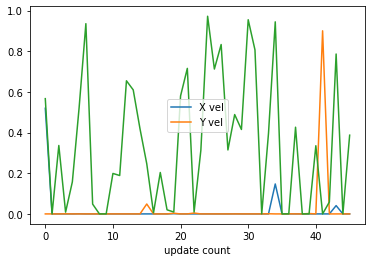

In [76]:
n_roi_neuron = 0
print(f'we look at the batched p_value {n_roi_neuron}')
batch_pvalue_matrix_neuron = np.squeeze(batch_pvalue_matrix[:,n_roi_neuron,:])

plt.plot(batch_pvalue_matrix_neuron)
plt.xlabel('update count')
plt.legend(['X vel', 'Y vel'])

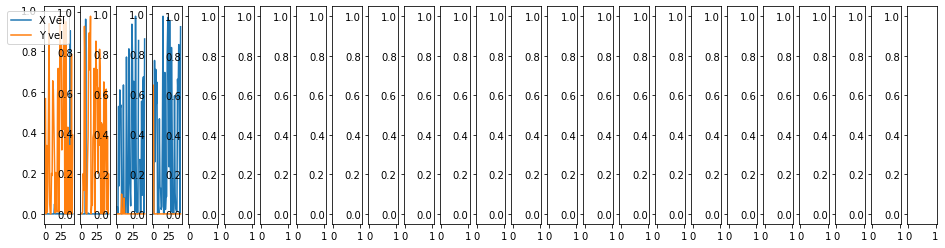

In [77]:



fig, axs = plt.subplots(1,N_NEURONS, figsize = (16,4))

for n in range(N_NEURONS):
    
    
    
    batch_pvalue_matrix_neuron = np.squeeze(batch_pvalue_matrix[:,n,:])
    axs[n].plot(batch_pvalue_matrix_neuron[:,1:])
    
    
    if n == 0: axs[n].legend(['X Vel', 'Y vel'])




the batch time is small
a batch should include at least 4 reaches.
very linear. all of a sudden, it gets way.

inside target, setting the int to zero. 
the hold vel is zero.  

## compare across conditions

In [78]:
for n in range(N_NEURONS):
    
    
    
    batch_pvalue_matrix_neuron = np.squeeze(batch_pvalue_matrix[:,n,:])
    axs[n].plot(batch_pvalue_matrix_neuron[:,1:])
    
    
    if n == 0: axs[n].legend(['X Vel', 'Y vel'])


# Assess lasso fit

In [79]:
spike_counts_batch = clda_params_dict['spike_counts_batch'] 
intended_kin = clda_params_dict['intended_kin']

print(f'spike_counts_batch has the shape of {spike_counts_batch.shape}')
print(f'intended_kin has the shape of {intended_kin.shape}')

print(f'kf_C has the shape of {kf_C.shape}')

spike_counts_batch has the shape of (46, 25, 50)
intended_kin has the shape of (46, 7, 50)
kf_C has the shape of (46, 25, 7)


In [80]:
VEL_DECODING_STATES = (X_VEL_STATE_IND, Y_VEL_STATE_IND,)
print(f'we will only be looking the indices of the x vel and y vel {VEL_DECODING_STATES}')

time_slice_of_interest = 0
print(f'time slice of interest {time_slice_of_interest}')

spike_count_slice = np.squeeze(spike_counts_batch[time_slice_of_interest, :, :])
intended_kin_slice = np.squeeze(intended_kin[time_slice_of_interest, VEL_DECODING_STATES, :])
kf_C_slice = np.squeeze(kf_C[time_slice_of_interest, :,VEL_DECODING_STATES])

#rotate the dimensions=
spike_count_slice = spike_count_slice.T
intended_kin_slice = intended_kin_slice.T
kf_C_slice = kf_C_slice.T


print(f'spike_count_slice has the shape of {spike_count_slice.shape}')
print(f'intended_kin_slice has the shape of {intended_kin_slice.shape}')

print(f'kf_C_slice has the shape of {kf_C_slice.shape}')

we will only be looking the indices of the x vel and y vel (3, 5)
time slice of interest 0
spike_count_slice has the shape of (50, 25)
intended_kin_slice has the shape of (50, 2)
kf_C_slice has the shape of (25, 2)


In [81]:
kf_C_slice

array([[ 5.96, -0.27],
       [ 0.04,  0.35],
       [ 0.45,  3.96],
       [ 2.15,  0.09],
       [ 0.19, -0.99],
       [-0.19, -0.52],
       [-0.22,  0.39],
       [-0.26, -0.01],
       [-0.18, -0.18],
       [-0.82, -0.45],
       [-0.62, -0.34],
       [-0.58,  0.23],
       [-0.09,  0.53],
       [ 0.18,  0.01],
       [-0.67,  0.48],
       [ 0.96,  0.93],
       [ 0.4 , -0.08],
       [ 0.15, -0.35],
       [ 0.2 ,  0.27],
       [ 0.29,  0.2 ],
       [ 0.32,  0.47],
       [-0.03, -0.37],
       [-0.54, -0.22],
       [-0.61, -0.5 ],
       [ 0.16, -0.33]])

this matrix differs from below
because this is mixed from the intial model

In [82]:
from sklearn import linear_model


linear_reg_model = linear_model.LinearRegression()
linear_reg_model.fit(intended_kin_slice, 
        spike_count_slice)

linear_reg_model.coef_

array([[ 9.67,  0.44],
       [-0.06, -0.07],
       [ 1.11,  8.77],
       [ 2.03,  0.14],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ]])

## Fit to Lasso path

In [83]:


clf = linear_model.Lasso(alpha = 1,
    max_iter = 100000)
clf.fit(spike_count_slice, intended_kin_slice)

print(clf.coef_)

[[ 0.08 -0.   -0.02  0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.  ]
 [-0.01 -0.    0.1  -0.03  0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.  ]]


apparently, we have this

In [84]:
(N_BATCHES, N_NEURONS, N_POINTS_IN_A_BATCH)  =  spike_counts_batch.shape
lasso_alpha = 1

#initialize an nan array
lasso_coefs = np.empty((N_BATCHES, len(VEL_DECODING_STATES), N_NEURONS))
lasso_coefs[:] = np.nan

for n_slice in range(N_BATCHES):
    #get the exact dimensions
    spike_count_slice = np.squeeze(spike_counts_batch[n_slice, :, :])
    intended_kin_slice = np.squeeze(intended_kin[n_slice, VEL_DECODING_STATES, :])
    
    #rotate the dimensions=
    spike_count_slice = spike_count_slice.T
    intended_kin_slice = intended_kin_slice.T

    
    clf = linear_model.Lasso(alpha = lasso_alpha,
        max_iter = 100000)
    clf.fit(spike_count_slice, intended_kin_slice)


    lasso_coefs[n_slice,:,:] = clf.coef_
    

In [85]:
print('to use the weight function, we need to swap axis')
OLD_NEURON_AXIS = 2
OLD_STATE_AXIS = 1

lasso_coefs = np.swapaxes(lasso_coefs, OLD_NEURON_AXIS, OLD_STATE_AXIS)
print(f'the new lasso coef has axis of {lasso_coefs.shape}')

lasso_coefs_over_batches = calc_a_history_of_matrix_L2norms_along_first_axis(lasso_coefs,
                                                                       (0,1))


lasso_coefs_over_batches.shape

to use the weight function, we need to swap axis
the new lasso coef has axis of (46, 25, 2)


(46, 25)

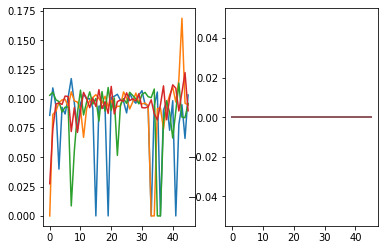

In [86]:
figure_lasso, lasso_axes = plt.subplots(1,2)

encoding_neurons_of_interest = range(4)
nonencoding_neurons_of_interest = range(4, 20)

lasso_axes[0].plot(lasso_coefs_over_batches[:, encoding_neurons_of_interest])

lasso_axes[1].plot(lasso_coefs_over_batches[:,nonencoding_neurons_of_interest])


kf_slice has kf_slice has shape (25, 2)


Text(0.5, 0, 'update batch number')

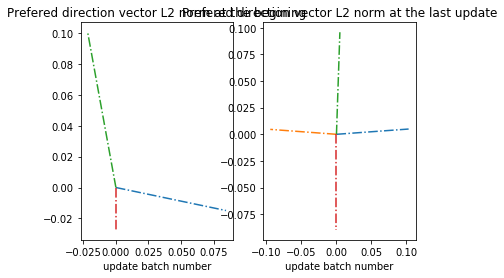

In [87]:
figure_lasso_directions, lasso_pds_axes = plt.subplots(1,2)


time_of_interest = 0
lasso_slice_start = np.squeeze(lasso_coefs[time_of_interest, :,:])
print(f'kf_slice has kf_slice has shape {lasso_slice_start.shape}')

lasso_slice_end = np.squeeze(lasso_coefs[-1, :,:])


#plot the begining 
plot_prefered_directions(lasso_slice_start, 
                         ax = lasso_pds_axes[0])
lasso_pds_axes[0].set_title('Prefered direction vector L2 norm at the begining')
lasso_pds_axes[0].set_xlabel('update batch number')



#plot the end
#plot the begining 
plot_prefered_directions(lasso_slice_end, 
                         ax = lasso_pds_axes[1])
lasso_pds_axes[1].set_title('Prefered direction vector L2 norm at the last update')
lasso_pds_axes[1].set_xlabel('update batch number')





## Cross-validate the fit

In [88]:
print('get a slice of data')
n_slice = 0

#get the exact dimensions
spike_count_slice = np.squeeze(spike_counts_batch[n_slice, :, :])
intended_kin_slice = np.squeeze(intended_kin[n_slice, VEL_DECODING_STATES, :])

#rotate the dimensions=
spike_count_slice = spike_count_slice.T
intended_kin_slice = intended_kin_slice.T

print(f'just to double check the shapes \
      spike_count_slice has a shape of {spike_count_slice.shape}\
      and intended_kin_slice has the shape of {intended_kin_slice.shape}')

get a slice of data
just to double check the shapes       spike_count_slice has a shape of (50, 25)      and intended_kin_slice has the shape of (50, 2)


In [89]:
eps = 1e-4 # this is the alpha range that we are interested in, right. 
CV = 5 
n_alphas = 100
print(f'to work with lasso regression, we are using an alpha range of {eps} as defined by alpha_min / alpha_max')
print(f'and we are doing {CV} fold validation')
print(f'and by default, we are using {n_alphas} alphas ')

lassoCV_result = linear_model.MultiTaskLassoCV(eps = eps,
                                     cv = CV).fit(spike_count_slice, intended_kin_slice)

print(f'lassoCV_result returns the best alpha of {lassoCV_result.alpha_}')
print(f'and the alphas we used are {lassoCV_result.alphas}')

to work with lasso regression, we are using an alpha range of 0.0001 as defined by alpha_min / alpha_max
and we are doing 5 fold validation
and by default, we are using 100 alphas 
lassoCV_result returns the best alpha of 0.09995493387489432
and the alphas we used are None


## Visualize the lasso path

In [90]:
from sklearn.linear_model import lasso_path

#determine the error tolerance
eps = 3e-5

alpha_lasso, coefs_lasso,_  = lasso_path(intended_kin_slice,
                                     spike_count_slice)


print(f'alphas have the shape of {alpha_lasso.shape}')
print(f'coefs have the shape of {coefs_lasso.shape}')

coef_dim_1, coef_2, coef_3 = coefs_lasso.shape


reshaped_coefs_lasso = np.reshape(
    coefs_lasso, (coef_dim_1 * coef_2, coef_3), order = 'F' #Fortan like column first like reshaping
)
print('transpose for plotting')
reshaped_coefs_lasso = reshaped_coefs_lasso.T
print(f'reshaped coefs array has dimension of {reshaped_coefs_lasso.shape}')

alphas have the shape of (100,)
coefs have the shape of (25, 2, 100)
transpose for plotting
reshaped coefs array has dimension of (100, 50)


let plot the coefficient trajectory


Text(0, 0.5, 'Coefficients')

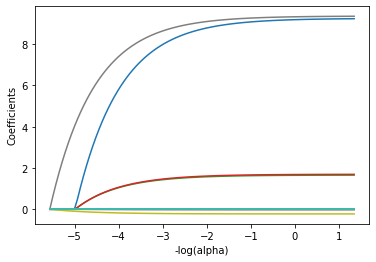

In [91]:
print('let plot the coefficient trajectory')

neg_log_alpha_lasso = - np.log(alpha_lasso)

plt.plot(neg_log_alpha_lasso, reshaped_coefs_lasso)
plt.xlabel('-log(alpha)')
plt.ylabel('Coefficients')

In [92]:
print('reorient the array')

reorient the array


In [93]:
a = np.array([
    [[1,2],[0,1]],
    [[1,2],[1,2]],
    [[3,4],[5,6]]
])
print(a.shape)
print(a)

(3, 2, 2)
[[[1 2]
  [0 1]]

 [[1 2]
  [1 2]]

 [[3 4]
  [5 6]]]


In [94]:
np.ravel(a)
        

array([1, 2, 0, 1, 1, 2, 1, 2, 3, 4, 5, 6])

In [95]:
np.reshape(a, (6,2), order = 'F')

array([[1, 2],
       [1, 2],
       [3, 4],
       [0, 1],
       [1, 2],
       [5, 6]])

## Fit lasso to accumulating data

In [96]:
(N_BATCHES, N_NEURONS, N_POINTS_IN_A_BATCH)  =  spike_counts_batch.shape
(N_BATCHES, N_STATES, N_POINTS_IN_A_BATCH) = intended_kin.shape

print(f'{intended_kin.shape}')

(46, 7, 50)


In [97]:
print('we are gonna swap axes for the state as well as ')
OLD_NEURON_AXIS = OLD_STATE_AXIS = 1
OLD_BATCH_TIME_AXIS =  2

spike_counts_batch_reshape = np.swapaxes(spike_counts_batch, OLD_BATCH_TIME_AXIS,OLD_NEURON_AXIS)
intended_kin_reshape = np.swapaxes(intended_kin, OLD_BATCH_TIME_AXIS,OLD_STATE_AXIS)


print(spike_counts_batch_reshape.shape)
print(f'the new intended kin has batch time axis as {intended_kin_reshape.shape}')

we are gonna swap axes for the state as well as 
(46, 50, 25)
the new intended kin has batch time axis as (46, 50, 7)


In [98]:
N_DECODING_STATES = len(VEL_DECODING_STATES)


lasso_alpha_all = [1, 10, 100]


lasso_coefs_all = list()
ols_coefs_all = list()

for lasso_alpha in lasso_alpha_all:
    #initialize an nan array
    lasso_coefs_accumulate = np.empty((N_BATCHES,N_DECODING_STATES, N_NEURONS))
    lasso_coefs_accumulate[:] = np.nan

    #initialize 
    ols_coefs_accumulate = np.empty((N_BATCHES,N_DECODING_STATES, N_NEURONS))
    ols_coefs_accumulate[:] = np.nan
    

    for n_batch in range(1,N_BATCHES):


        spike_count_reshape_slice = np.reshape(spike_counts_batch_reshape[:n_batch, :, :], 
                                               (-1, N_NEURONS)) #keep the neurons and layout the batches

        intended_kin_reshape_slice = np.reshape(intended_kin_reshape[:n_batch, :, VEL_DECODING_STATES],
                                               (-1, N_DECODING_STATES))

        print(spike_count_reshape_slice.shape)
        print(intended_kin_reshape_slice.shape)


        clf = linear_model.Lasso(alpha = lasso_alpha, max_iter = 100000)
        clf.fit(spike_count_reshape_slice, intended_kin_reshape_slice)

        ols = linear_model.LinearRegression()
        ols.fit(spike_count_reshape_slice, intended_kin_reshape_slice)

        lasso_coefs_accumulate[n_batch,:,:] = clf.coef_

        ols_coefs_accumulate[n_batch,:,:] = ols.coef_
    
    lasso_coefs_all.append(lasso_coefs_accumulate)
    ols_coefs_all.append(ols_coefs_accumulate)
    

(50, 25)
(50, 2)
(100, 25)
(100, 2)
(150, 25)
(150, 2)
(200, 25)
(200, 2)
(250, 25)
(250, 2)
(300, 25)
(300, 2)
(350, 25)
(350, 2)
(400, 25)
(400, 2)
(450, 25)
(450, 2)
(500, 25)
(500, 2)
(550, 25)
(550, 2)
(600, 25)
(600, 2)
(650, 25)
(650, 2)
(700, 25)
(700, 2)
(750, 25)
(750, 2)
(800, 25)
(800, 2)
(850, 25)
(850, 2)
(900, 25)
(900, 2)
(950, 25)
(950, 2)
(1000, 25)
(1000, 2)
(1050, 25)
(1050, 2)
(1100, 25)
(1100, 2)
(1150, 25)
(1150, 2)
(1200, 25)
(1200, 2)
(1250, 25)
(1250, 2)
(1300, 25)
(1300, 2)
(1350, 25)
(1350, 2)
(1400, 25)
(1400, 2)
(1450, 25)
(1450, 2)
(1500, 25)
(1500, 2)
(1550, 25)
(1550, 2)
(1600, 25)
(1600, 2)
(1650, 25)
(1650, 2)
(1700, 25)
(1700, 2)
(1750, 25)
(1750, 2)
(1800, 25)
(1800, 2)
(1850, 25)
(1850, 2)
(1900, 25)
(1900, 2)
(1950, 25)
(1950, 2)
(2000, 25)
(2000, 2)
(2050, 25)
(2050, 2)
(2100, 25)
(2100, 2)
(2150, 25)
(2150, 2)
(2200, 25)
(2200, 2)
(2250, 25)
(2250, 2)
(50, 25)
(50, 2)
(100, 25)
(100, 2)
(150, 25)
(150, 2)
(200, 25)
(200, 2)
(250, 25)
(250, 2)
(3

In [99]:
lasso_coefs_all =  np.array(lasso_coefs_all)
ols_coefs_all = np.array(ols_coefs_all)
print(f'the alpha scanning has a shape of {lasso_coefs_all.shape}')
print(f'the alphas has a shape of {ols_coefs_all.shape}')

the alpha scanning has a shape of (3, 46, 2, 25)
the alphas has a shape of (3, 46, 2, 25)


(46, 2, 25)
let look at the coefficients



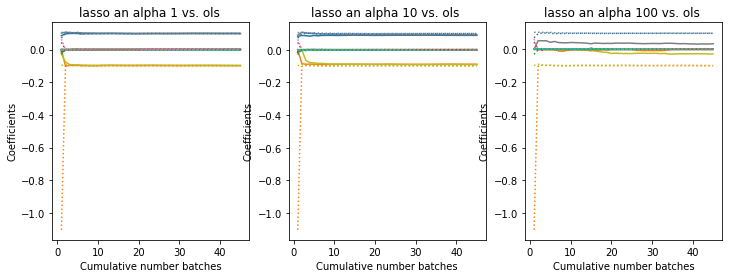

In [100]:
print(lasso_coefs_accumulate.shape)
print('lets look at the coefficients')

figure, axes = plt.subplots(1, len(lasso_alpha_all), figsize = (12, 4))

for i,a in enumerate(lasso_alpha_all):
    
    lasso_coefs_accumulate = np.squeeze(lasso_coefs_all[i, :,:,:])
    ols_coefs_accumulate = np.squeeze(ols_coefs_all[i, :,:,:])

    axes[i].plot(np.reshape(lasso_coefs_accumulate, (N_BATCHES, -1)))

    #plot the ols
    axes[i].plot(np.reshape(ols_coefs_accumulate, (N_BATCHES, -1)),
            linestyle = 'dotted')
    
    axes[i].set_title(f'lasso an alpha {lasso_alpha_all[i]} vs. ols ')

    axes[i].set_xlabel('Cumulative number batches')
    axes[i].set_ylabel('Coefficients')


print()